In [86]:
# load data from test and train csv files

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import optuna
import sklearn.model_selection
import sklearn.metrics
import sklearn.svm
import sklearn.ensemble

In [87]:
# Load data
def load_data():
    train = pd.read_csv('../playground-series-s4e5/train.csv')
    test = pd.read_csv('../playground-series-s4e5/test.csv')
    return train, test

train, test = load_data()
# call the id column from the test data
ids = test['id']

In [89]:
# Preprocess data

def preprocess_data(train, test):
    # Drop columns
    train = train.drop(['id'], axis=1)
    test = test.drop(['id'], axis=1)
    # Split data
    X = train.drop(['FloodProbability'], axis=1)
    y = train['FloodProbability']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_valid, y_train, y_valid, test

In [80]:
#standardize the data using the StandardScaler
from sklearn.preprocessing import StandardScaler

def standardize_data(X_train, X_valid, test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    test = scaler.transform(test)
    return X_train, X_valid, test

In [91]:
X_train, X_valid, y_train, y_valid, test = preprocess_data(train, test)
X_train, X_valid, test = standardize_data(X_train, X_valid, test)

In [92]:
# Define an objective function to be minimized.
def objective(trial):
    # Suggest hyperparameters
    params = {
        'learning_rate': trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        'max_depth': trial.suggest_int("max_depth", 1, 5),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 1.0),
        'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),
        'objective': 'reg:squarederror',
        'n_estimators': 1000,
    }

    # Create an XGBoost model
    model = xgb.XGBRegressor(**params)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_valid)

    # Evaluate the model
    R2 = r2_score(y_valid, predictions)

    return R2 # An objective value linked with the Trial object.

# Create a new study.
study = optuna.create_study(direction='maximize')

# Invoke optimization of the objective function.
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

[I 2024-05-07 14:38:37,129] A new study created in memory with name: no-name-68e04f70-bbaa-4b3c-981c-3e4f2629f847
[I 2024-05-07 14:39:00,543] Trial 0 finished with value: 0.03176889288165208 and parameters: {'learning_rate': 0.00013288612396870333, 'max_depth': 5, 'subsample': 0.5235766548407504, 'colsample_bytree': 0.8566606759009574, 'min_child_weight': 3}. Best is trial 0 with value: 0.03176889288165208.
[I 2024-05-07 14:39:17,257] Trial 1 finished with value: 0.4390177753057761 and parameters: {'learning_rate': 0.00386995426163339, 'max_depth': 4, 'subsample': 0.9230382599364313, 'colsample_bytree': 0.5878506399575252, 'min_child_weight': 1}. Best is trial 1 with value: 0.4390177753057761.
[I 2024-05-07 14:39:25,146] Trial 2 finished with value: 0.013191065420500192 and parameters: {'learning_rate': 0.0002778177075926816, 'max_depth': 1, 'subsample': 0.8615974103297087, 'colsample_bytree': 0.6094253156938924, 'min_child_weight': 4}. Best is trial 1 with value: 0.4390177753057761.
[

In [62]:
# Initial Setup
# Create the XGBoost model
train_model = xgb.XGBRegressor(
    learning_rate=study.best_params['learning_rate'],
    max_depth=study.best_params['max_depth'],
    subsample=study.best_params['subsample'],
    colsample_bytree=study.best_params['colsample_bytree'],
    min_child_weight=study.best_params['min_child_weight'],
    objective='reg:squarederror',
    n_estimators=100,
)
model = train_model.fit(X_train, y_train) # fit the model
predictions = model.predict(test) # make predictions
print(predictions) # print predictions
print(r2_score(y_valid, predictions)) # print the r2 score

[0.51564    0.52135694 0.5226786  ... 0.54807925 0.49095944 0.5258327 ]
0.4824732673372316


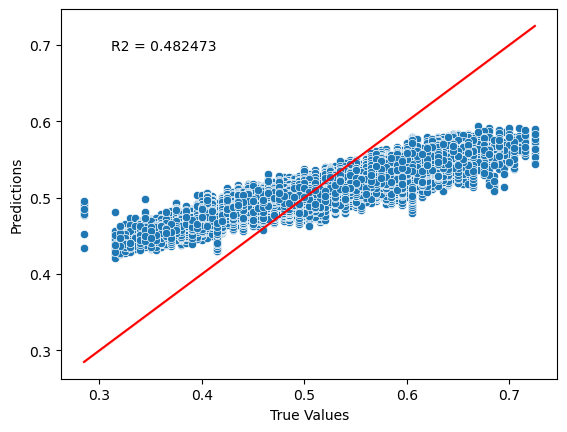

In [63]:
#plot the predictions
sns.scatterplot(x=y_valid, y=predictions)
#draw regression line
sns.lineplot(x=y_valid, y=y_valid, color='red')
#show R2 score inside the plot
plt.text(0.1, 0.9, 'R2 = %f' % r2_score(y_valid, predictions), ha='left', va='center', transform=plt.gca().transAxes)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


In [61]:
#saving to submission.csv

# Combine ids and predictions into a structured array
combined_data = np.array(list(zip(ids, predictions)), dtype=[('id', int), ('FloodProbability', float)])

# Define the header
header = 'id,FloodProbability'

# Save to CSV with header
np.savetxt('submission.csv', combined_data, delimiter=',', header=header, fmt='%d,%.2f', comments='')



